Note! The plots in this notebook should also work interactively by using matplotlib TkAgg

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
from utils.utils_numpy import nrmse
from utils.utils_vis import title_font_size, axis_font_size, ticks_font_size, width_in_inches, pk_param_names, pk_param_units, pk_bounds
from matplotlib.gridspec import GridSpec
%matplotlib inline
import matplotlib
from matplotlib.gridspec import GridSpec

In [ ]:
save = False
if save:
    outpath = "output/vis_report_final"
    for subfolder in ["aleatoric", "epistemic", "vivo", "appendix"]:
        if not os.path.exists(f"{outpath}/{subfolder}"):
            os.makedirs(f"{outpath}/{subfolder}")

In [ ]:
slice1 = np.load('data/vivo/slice1.npz')
data = slice1['data']
mask = slice1['mask']
ct = slice1['ct']
shape = ct.shape


In [28]:
pred_paths = {
    'PINN (ens)' : 'output/vivo/pinn_ph_dcenet_ens/predictions',
    'MVE (ens)' : 'output/normal/mve_snn_dcenet_ens/predictions',
}

preds = {name: np.load(os.path.join(path, 'test_slices.npz'), allow_pickle=True)['slice1'] for name, path in pred_paths.items()}

preds = {
    name: preds[name].item() for name in pred_paths
}

titles ={
    "PINN (ens) (epi)" : "PINN-ens",#$(\\sigma_e^2)$",
    # "PINN (ens) (ale)" : "PINN $(\\sigma_a)$",
    "MVE (ens) (epi)" : "MVE-ens"#$(\\sigma_e^2)$",
    # "MVE (ens) (ale)" : "MVE $(\\sigma_a)$",
}

pred_params = {}
pred_params_full = {}
pred_vars = {}
pred_errors = {}
reconstructions = {}
rec_errors = {}

for ens in pred_paths:
    ens_epi = ens + " (epi)"
    # ens_ale = ens + " (ale)"
    pred_param = preds[ens]["pred"]
    pred_params[ens] = pred_param[:,[0,2,3]].reshape(shape[:2] + (3,))
    pred_params_full[ens] = pred_param.reshape(shape[:2] + (4,))
    recs = preds[ens]["reconstruction"]
    reconstructions[ens] = recs.reshape(shape[:2] + (80,))
    print(f"{ens}: {np.median(preds[ens]["var_ep"][:,[0,2,3]], axis=0)}")
    print(f"{ens}: {preds[ens]["var_ep"][:,[0,2,3]].std(axis=0)}")

    uct_epi = preds[ens]["var_ep"][:,[0,2,3]]
    pred_vars[ens_epi] = uct_epi.reshape(shape[:2] + (3,))    
    pred_errors[ens_epi] = np.sqrt(uct_epi * 2 / np.pi).reshape(shape[:2] + (3,))
    rec_errors[ens_epi] = np.abs(reconstructions[ens] - ct).mean(axis=-1) * mask


PINN (ens): [1.4289014e-02 5.5492390e-05 3.5150554e-06]
PINN (ens): [0.04084661 0.00074675 0.00074105]
MVE (ens): [1.3936162e-02 4.8558949e-04 2.2270367e-05]
MVE (ens): [0.03523927 0.00192214 0.00025037]


/var/folders/qr/7p6fvn3d4nd67dkshxhb1vt00000gn/T/ipykernel_54832/3306621020.py:39: RuntimeWarning: invalid value encountered in sqrt
  pred_errors[ens_epi] = np.sqrt(uct_epi * 2 / np.pi).reshape(shape[:2] + (3,))


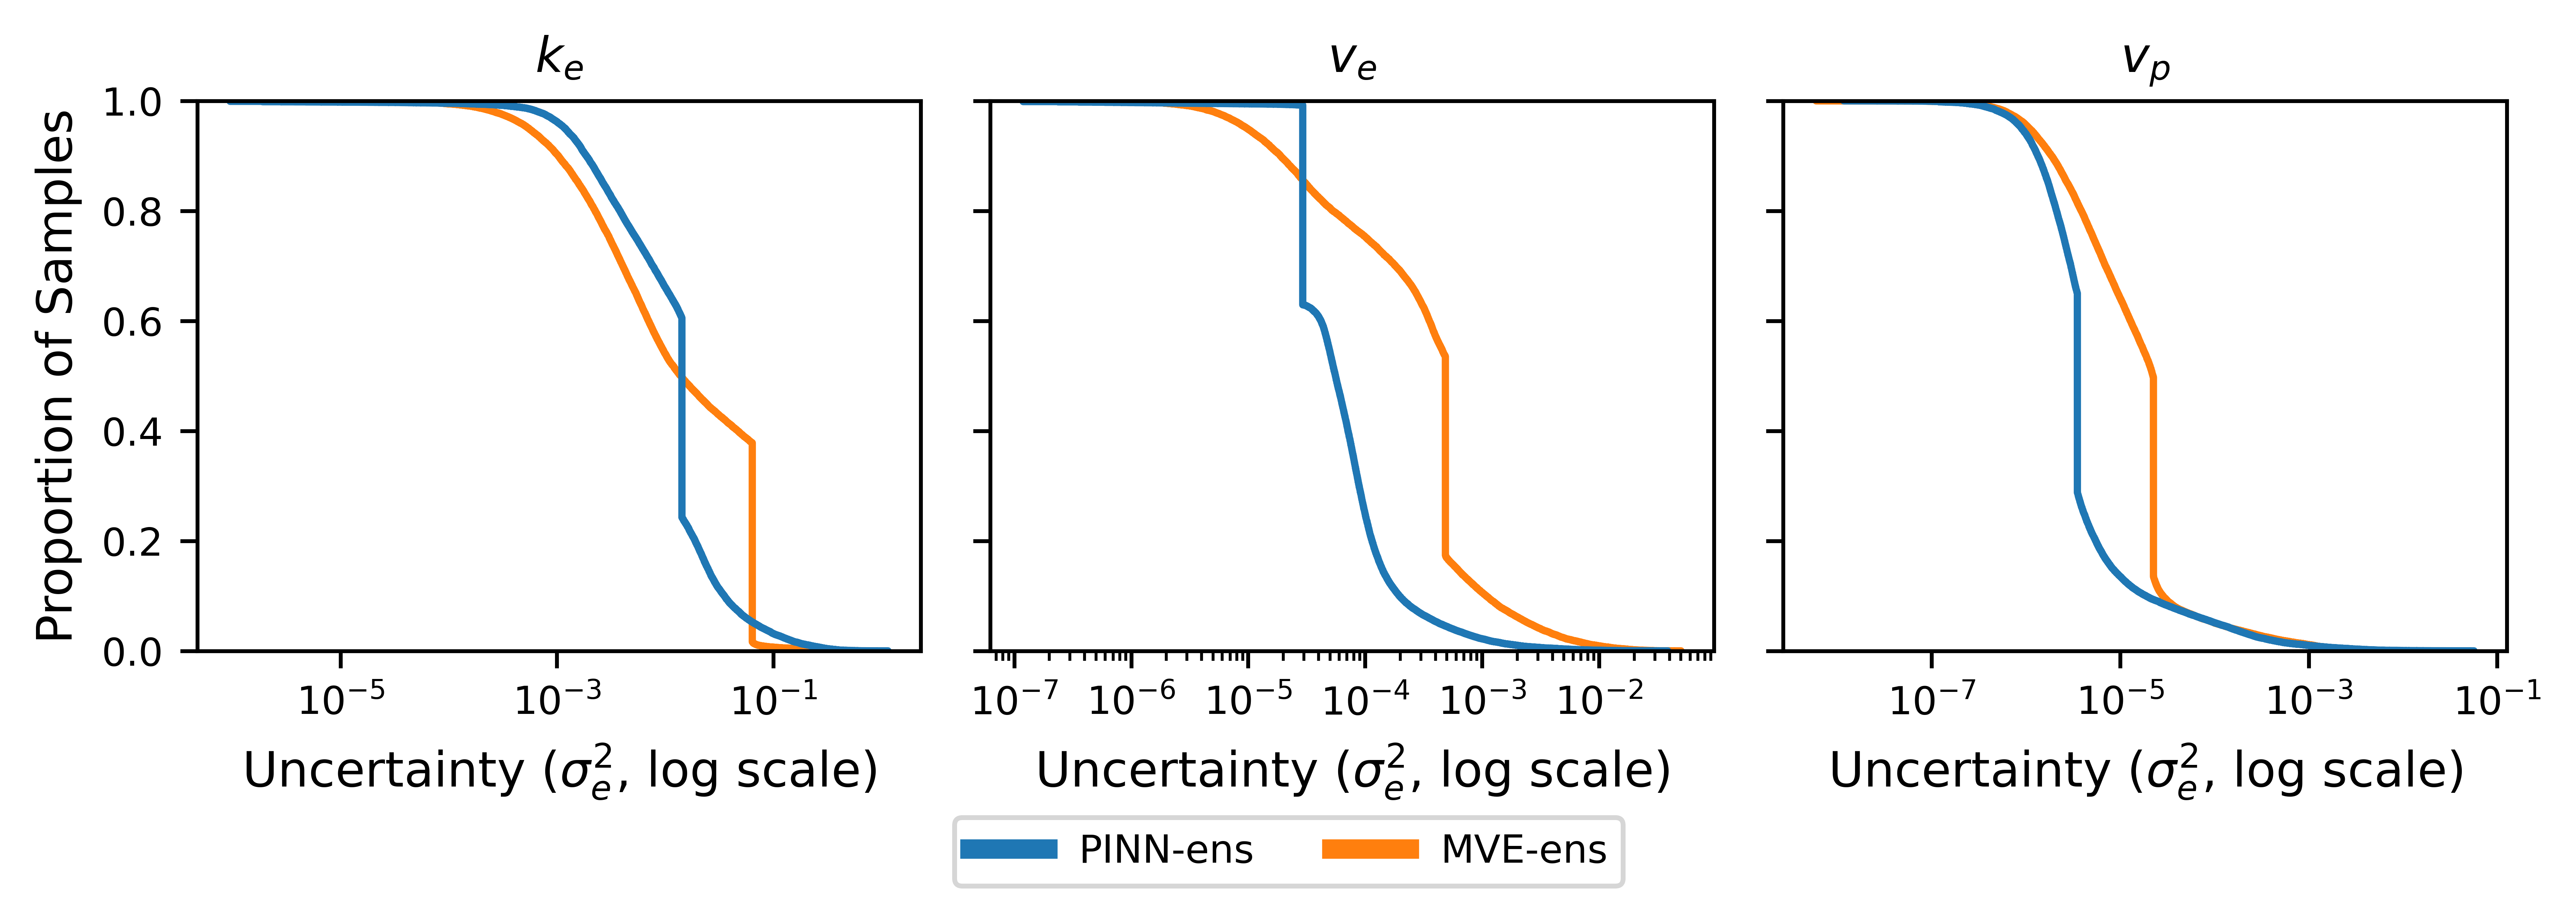

In [29]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Flatten and prepare data for all models/parameters
records = []

for key, variances in pred_vars.items():
    for i, param_name in enumerate(pk_param_names):
        param_variances = variances[..., i].flatten()
        param_variances = param_variances[param_variances > 0]  # Keep positive values
        for v in param_variances:
            records.append({
                "Uncertainty": v,
                "Model": titles[key],
                "Parameter": param_name
            })

# Create a long-form DataFrame for Seaborn
df = pd.DataFrame.from_records(records)

# Create subplots: 1 row, one plot per parameter
n_params = len(pk_param_names)
fig, axs = plt.subplots(1, n_params, figsize=(width_in_inches, width_in_inches/3), sharey=True, dpi=1000)

if n_params == 1:
    axs = [axs]  # Ensure it's iterable

# Plot using Seaborn
for i, param_name in enumerate(pk_param_names):
    ax = axs[i]
    sns.ecdfplot(
        data=df[df["Parameter"] == param_name],
        x="Uncertainty",
        hue="Model",
        ax=ax,
        log_scale=True,  # Logarithmic x-axis
        legend=False,
        complementary=True
    )
    ax.set_title(f"{param_name}", fontsize=axis_font_size)
    ax.set_xlabel("Uncertainty ($\\sigma^2_e$, log scale)", fontsize=axis_font_size)
    ax.set_ylabel("Proportion of Samples", fontsize=axis_font_size)
    ax.tick_params(axis='both', which='major', labelsize=ticks_font_size)

# add legend
handles = [
    plt.Line2D([0], [0], color=sns.color_palette()[i], lw=4) for i in range(len(titles))
]
labels = [
    titles[key] for key in titles if key in pred_vars.keys()
]
fig.legend(
    handles,
    labels,
    loc='lower center',
    bbox_to_anchor=(0.5, -0.06),
    ncol=2,
    fontsize=ticks_font_size,
)

# plt.suptitle("Empirical CDFs of Uncertainty Estimates", fontsize=title_font_size)
plt.tight_layout()

if save:
    plt.savefig(f"{outpath}/vivo/uncertainty_cdfs.jpg", dpi=1000, bbox_inches='tight')


PINN (ens) (epi) - $k_e$: lambda= 48.41983616271173
KS test statistic: 0.2577, p-value: 0.0
PINN (ens) (epi) - $v_e$: lambda= 6285.298065152477
KS test statistic: 0.2891, p-value: 0.0
PINN (ens) (epi) - $v_p$: lambda= 17377.3343507277
KS test statistic: 0.7187, p-value: 0.0
MVE (ens) (epi) - $k_e$: lambda= 31.92485187945227
KS test statistic: 0.2480, p-value: 0.0
MVE (ens) (epi) - $v_e$: lambda= 1379.8677199576496
KS test statistic: 0.3380, p-value: 0.0
MVE (ens) (epi) - $v_p$: lambda= 19526.694756678822
KS test statistic: 0.5085, p-value: 0.0


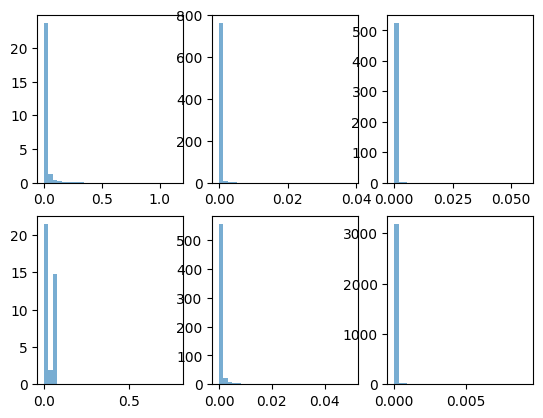

In [21]:
from scipy.stats import expon, kstest


# make 2x3 subplots
fig, axs = plt.subplots(2, 3)

for j,(key, variances) in enumerate(pred_vars.items()):
    for i, param_name in enumerate(pk_param_names):
        param_variances = variances[..., i].flatten()

        # exponential fit
        loc, scale = expon.fit(param_variances[param_variances>0], floc=0)
        ld = 1 / scale
        print(f"{key} - {param_name}: lambda= {ld}")
        x = np.linspace(0, np.percentile(param_variances, 99), 100)
        pdf_fitted = expon.pdf(x, loc=0, scale=scale)

        # plot fit
        axs[j,i].hist(param_variances, bins=30, density=True, alpha=0.6, label='Empirical')
        # axs[j,i].plot(x, pdf_fitted, 'r-', label='Fitted Exponential')

        # kolmogorov-smirnov test
        ks_stat, p_value = kstest(param_variances, 'expon', args=(0, scale))
        print(f"KS test statistic: {ks_stat:.4f}, p-value: {p_value}")

plt.show()

In [90]:
%matplotlib inline
import matplotlib
from matplotlib.gridspec import GridSpec
# matplotlib.use('TkAgg')
plt.ion()
colors = ['tab:cyan', 'lime']
coords = [82, 120]
# coords2 = [126, 65] # kidney
# coords2 = [88, 55] # liver
clicked_ax=7
def on_click(event):
    global coords
    global coords2
    global clicked_ax
    for i, ax in enumerate(axs.flatten()):
        if event.inaxes == ax:
            xdata, ydata = ax.transData.inverted().transform([event.x, event.y])
            coords = [int(round(ydata)), int(round(xdata))]
            clicked_ax = i
            print(f"Clicked coordinates in subplot: {coords}")  # For debugging
            update_plots()
            break

def update_plots():
    for ax in axs.flatten():
        ax.clear()
    ax_curve_1.clear()

    for i,ens in enumerate(pred_vars.keys()):
        # display rec error
        title = titles[ens]
        if i == 0:
            axs[0, i].set_ylabel("$k_e$ ($min^{-1}$)", fontsize=axis_font_size, rotation=90)
            axs[1, i].set_ylabel(f'$v_e$ ({pk_param_units[1]})', fontsize=axis_font_size, rotation=90) 
            axs[2, i].set_ylabel(f'$v_p$ ({pk_param_units[2]})', fontsize=axis_font_size, rotation=90)
            axs[3, i].set_ylabel('Rec. Err. ($mM$)', fontsize=axis_font_size)

        for j in range(3):
            # im = axs[j, i].imshow(pred_vars[ens][:,:,j]*mask, cmap='inferno', vmin=0, vmax=pk_bounds[j], interpolation='none')
            cbar = plt.colorbar(axs[j, i].imshow(pred_vars[ens][:,:,j]*mask, cmap='inferno', vmin=0, vmax=[0.08, 0.001, 0.0005][j], interpolation='none'), ax=axs[j, i], orientation='vertical',shrink=0.9)
            cbar.ax.tick_params(labelsize=ticks_font_size)
            cbar.ax.ticklabel_format(style='sci', scilimits=(-3,4))
            axs[j, i].plot(coords[1], coords[0], 'x', color=colors[0], markersize=5)
            axs[j, i].set_xticks([])
            axs[j, i].set_yticks([])
            if j == 0:
                axs[j, i].set_title(title, fontsize=axis_font_size)
        
        # im = axs[3, i].imshow(rec_errors[ens]*mask, cmap='inferno', vmin=0, vmax=np.percentile(rec_errors[ens], 99), interpolation='none')
        cbar = plt.colorbar(axs[3, i].imshow(rec_errors[ens]*mask, cmap='inferno', vmin=0, vmax=np.percentile(rec_errors[ens], 99), interpolation='none'), ax=axs[3, i], orientation='vertical', shrink=0.9)
        # cbar.ax.tick_params(labelsize=ticks_font_size)
        axs[3, i].plot(coords[1], coords[0], 'x',color=colors[0], markersize=5)
        # axs[3, i].plot(coords2[1], coords2[0], 'x',color=colors[1], markersize=1)
        # axs[3, i].text(0.5, -0.13, f'{rec_errors[ens][coords[0], coords[1]]:.3f}', horizontalalignment='center', verticalalignment='center', transform=axs[3, i].transAxes, fontsize=ticks_font_size, color='black')
        axs[3, i].set_xticks([])
        axs[3,i].set_yticks([])

    # add large subplot to the right, showing the curve, at ax[:, -1]
    ax = ax_curve_1
    time_in_minutes = np.arange(0, 80) / 60 * 4
    ax.plot(time_in_minutes, ct[coords[0], coords[1]], label='Input', color='black', linewidth=1.0)
    ax.plot(time_in_minutes, reconstructions["PINN (ens)"][coords[0], coords[1]], label='PINN-ens', alpha=1.0, linestyle='--', color=colors[0], linewidth=1.0)
    ax.plot(time_in_minutes, reconstructions["MVE (ens)"][coords[0], coords[1]], label='MVE-ens', alpha=1.0, linestyle='-', color=colors[0], linewidth=1.0)
    # ax.set_title('Curves', fontsize=axis_font_size)
    ax.tick_params(axis='both', which='major', labelsize=ticks_font_size)
    ax.legend(fontsize=ticks_font_size)
    ax.set_xlabel('Time (min)', fontsize=axis_font_size)
    ax.set_ylabel('Concentration ($mM$)', fontsize=axis_font_size)
    # fig.canvas.draw()
    # fig.tight_layout()

    # ax = ax_curve_2
    # ax.plot(ct[coords2[0], coords2[1]], label='Input', color='black', linewidth=1.0)
    # ax.plot(reconstructions["PINN (ens)"][coords2[0], coords2[1]], label='PINN (ens)', alpha=1.0, linestyle='--', color=colors[1], linewidth=1.0)
    # ax.plot(reconstructions["MVE (ens)"][coords2[0], coords2[1]], label='MVE (ens)', alpha=1.0, linestyle='-', color=colors[1], linewidth=1.0)
    # ax.tick_params(axis='both', which='major', labelsize=ticks_font_size-2)
    # ax.legend(fontsize=ticks_font_size-2)


    # draw histograms of clicked parameters
    print(clicked_ax)
    ind = clicked_ax//2-1
    if ind >= 0:
        # for j,ens in enumerate(pred_paths.keys()):
        # for j,ens in enumerate(['MVE (ens)']):
        #     pred_p = pred_params[ens][:,:,ind]
        #     axs_hist[j].clear()
        #     axs_hist[j].hist(pred_p[mask > 0], bins=50, alpha=0.5, label=ens)
        #     axs_hist[j].axvline(pred_p[coords[0], coords[1]], color='r', label='Clicked')
        #     # print(f"{ens} - coords a: {pred_p[coords[0], coords[1]]}")
        #     # print(f"{ens} - coords b: {pred_p[coords2[0], coords2[1]]}")
        #     axs_hist[j].set_title(f'{ens[:-6]} {["$k_e$", "$v_e$", "$v_p$"][ind]}', fontsize=axis_font_size)
        #     # axs_hist[j].legend(fontsize=ticks_font_size)
        #     axs_hist[j].tick_params(axis='both', which='major', labelsize=ticks_font_size)
        #     axs_hist[j].set_yscale('log')
        
        pred_p = pred_vars['MVE (ens) (epi)'][:,:,ind]
        axs_hist.clear()
        axs_hist.hist(pred_p[mask > 0], bins=20, alpha=1.0, label='MVE epistemic uncertainties')
        axs_hist.axvline(pred_p[coords[0], coords[1]], color=colors[0], label='Selected voxel')
        # axs_hist.set_title(f'{ens[:-6]} {["$k_e$", "$v_e$", "$v_p$"][ind]}', fontsize=axis_font_size)
        axs_hist.legend(fontsize=ticks_font_size)
        axs_hist.tick_params(axis='both', which='major', labelsize=ticks_font_size)
        axs_hist.set_yscale('log')
        axs_hist.set_xlabel(f'$\\sigma^2_e$ in {pk_param_names[ind]}', fontsize=axis_font_size)
        axs_hist.set_ylabel('Counts (log)', fontsize=axis_font_size)
        # axs_hist.set_xlim(pk_bounds[ind])
        # axs_hist.set_ylim(1e-2, 1e4)

    fig.canvas.draw()
    fig.tight_layout()

fig = plt.figure(figsize=(width_in_inches, width_in_inches), dpi=1000)
gs = GridSpec(4, len(pred_vars)+1, figure=fig, width_ratios=[5, 5, 8])#, wspace=0.26, hspace=0.31)

# Define axes for each subplot
axs = np.empty((4, len(pred_vars)), dtype=object)
for i in range(len(pred_vars)):
    axs[0, i] = fig.add_subplot(gs[0, i])
    axs[1, i] = fig.add_subplot(gs[1, i])
    axs[2, i] = fig.add_subplot(gs[2, i])
    axs[3, i] = fig.add_subplot(gs[3, i])

# Define the final subplot spanning multiple rows
ax_curve_1 = fig.add_subplot(gs[:2, -1:])
# ax_curve_2 = fig.add_subplot(gs[2:, -2:])
axs_hist = fig.add_subplot(gs[2:,-1:])#np.empty((2), dtype=object)
# axs_hist[0] = fig.add_subplot(gs[3:, -1])
# axs_hist[1] = fig.add_subplot(gs[3:, -1])
update_plots()
fig.canvas.mpl_connect('button_press_event', on_click)

# plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05)
# plt.tight_layout(pad=0.0)
if save:
    plt.savefig(f"{outpath}/vivo/epistemic_split.jpg", dpi=1000, format="jpg")



7
